# Assignment 4

Deadline: 30.04.2025 12:00 CET

<Add your name, student-id and emal address>

## Prerequisites: Library imports, data load and initialization of the backtest service

In [1]:
# Standard library imports
import os
import sys
import copy
from typing import Optional
from qpsolvers import solve_qp


# Third party imports
import numpy as np
import pandas as pd

# Add the project root directory to Python path
project_root = "/Users/elenetsaouse/qpmwp-course"
sys.path.append("/Users/elenetsaouse/qpmwp-course/qpmwp-course/src")
   # Change this path if needed
src_path = os.path.join(project_root, 'qpmwp-course\\src')
sys.path.append(project_root)
sys.path.append(src_path)

# Local modules imports
from helper_functions import load_data_spi, load_pickle
from estimation.covariance import Covariance
from estimation.expected_return import ExpectedReturn
from optimization.optimization import Optimization, Objective, MeanVariance
from optimization.optimization_data import OptimizationData
from optimization.constraints import Constraints
from backtesting.backtest_item_builder_classes import (
    SelectionItemBuilder,
    OptimizationItemBuilder,
)
from backtesting.backtest_item_builder_functions import (
    bibfn_selection_min_volume,
    bibfn_selection_gaps,
    bibfn_return_series,
    bibfn_budget_constraint,
    bibfn_box_constraints,
    bibfn_size_dependent_upper_bounds,
)
from backtesting.backtest_data import BacktestData
from backtesting.backtest_service import BacktestService
from backtesting.backtest import Backtest

In [2]:
# Load data
path_to_data = '/Users/elenetsaouse/qpmwp-course/qpmwp-course/data'  # <change this to your path to data>

# Load market and jkp data from parquet files
market_data = pd.read_parquet(f'/Users/elenetsaouse/Downloads/market_data.parquet')


# Instantiate the BacktestData class
# and set the market data and jkp data as attributes
data = BacktestData()
data.market_data = market_data
data.bm_series = load_data_spi(path='/Users/elenetsaouse/qpmwp-course/qpmwp-course/data') # <change this if necessary>

In [3]:
# Define rebalancing dates
n_days = 21*3
market_data_dates = market_data.index.get_level_values('date').unique().sort_values(ascending=True)
rebdates = market_data_dates[market_data_dates > '2015-01-01'][::n_days].strftime('%Y-%m-%d').tolist()

In [4]:
# Define the selection item builders.
selection_item_builders = {
    'gaps': SelectionItemBuilder(
        bibfn = bibfn_selection_gaps,
        width = 252*3,
        n_days = 10,
    ),
    'min_volume': SelectionItemBuilder(
        bibfn = bibfn_selection_min_volume,
        width = 252,
        min_volume = 500_000,
        agg_fn = np.median,
    ),
}

# Define the optimization item builders.
optimization_item_builders = {
    'return_series': OptimizationItemBuilder(
        bibfn = bibfn_return_series,
        width = 252*3,
        fill_value = 0,
    ),
    'budget_constraint': OptimizationItemBuilder(
        bibfn = bibfn_budget_constraint,
        budget = 1,
    ),
    'box_constraints': OptimizationItemBuilder(
        bibfn = bibfn_box_constraints,
        upper = 0.1,
    ),
    'size_dep_upper_bounds': OptimizationItemBuilder(
        bibfn = bibfn_size_dependent_upper_bounds,
        small_cap = {'threshold': 300_000_000, 'upper': 0.02},
        mid_cap = {'threshold': 1_000_000_000, 'upper': 0.05},
        large_cap = {'threshold': 10_000_000_000, 'upper': 0.1},
    ),
}

# Initialize the backtest service
bs = BacktestService(
    data = data,
    selection_item_builders = selection_item_builders,
    optimization_item_builders = optimization_item_builders,
    rebdates = rebdates,
)

## 1. Maximum Sharpe Ratio Portfolio

a) 

(6 points)

Complete the `MaxSharpe` class below by implementing your its methods `set_objective` and `solve`.
The `solve` method should implement an iterative algorithm that quickly approximates the "true" maximimum Sharpe ratio portfolio (given the estimates of mean and covariance). This approximation should be done by repeatedly solving a mean-variance optimization problem, where the risk aversion parameter (which scales the covariance matrix) is adjusted in each iteration. The algorithm should terminate after a maximum of 10 iterations. 

In [ ]:
class MaxSharpe(Optimization):

    def __init__(self,
                 constraints: Optional[Constraints] = None,
                 covariance: Optional[Covariance] = None,
                 expected_return: Optional[ExpectedReturn] = None,
                 **kwargs) -> None:
        super().__init__(
            constraints=constraints,
            **kwargs,
        )
        self.covariance = Covariance() if covariance is None else covariance
        self.expected_return = ExpectedReturn() if expected_return is None else expected_return

    def set_objective(self, optimization_data: OptimizationData) -> None:
        self.optimization_data = optimization_data

        X = optimization_data['return_series']
        mu = self.expected_return.estimate(X=X, inplace=False)
        covmat = self.covariance.estimate(X=X, inplace=False)
        ids = self.constraints.ids

        self.mu = pd.Series(mu, index=X.columns).reindex(ids).to_numpy()
        self.Sigma = pd.DataFrame(covmat, index=X.columns, columns=X.columns).reindex(index=ids, columns=ids).to_numpy()

        self.objective = Objective(
            q = -self.mu,
            P = 2 * self.Sigma,
        )
        return None

    def solve(self) -> None:
        max_iter = 10
        tol = 1e-6
        ids = self.constraints.ids
        n = len(ids)
        gamma = 1.0
        prev_weights = self.results.get('prev_weights', {})
        w_prev = np.array([prev_weights.get(i, 0.0) for i in ids])
        turnover_penalty = self.params.get('turnover_penalty', 0.0)

        for _ in range(max_iter):
            P = 2 * gamma * self.Sigma
            q = -self.mu.copy()

            if turnover_penalty:
                q += turnover_penalty * np.sign(w_prev)

            self.objective = Objective(P=P, q=q)
            self.params['x_init'] = dict(zip(ids, w_prev))
            super().solve()

            w_dict = self.results['weights']
            w = np.array([w_dict[i] for i in ids])

            ret = self.mu @ w
            var = w @ self.Sigma @ w

            if var <= 0:
                break

            new_gamma = ret / var
            if abs(new_gamma - gamma) < tol:
                w_prev = w
                break

            gamma = new_gamma
            w_prev = w

        final_w = dict(zip(ids, w_prev))
        self.results['weights'] = final_w
        self.results['prev_weights'] = final_w
        self.results['gamma'] = gamma
        self.results['status'] = True
        return None

b) 

(2 points)

Provide a theoretical or empirical justification that your algorithm converges to the true maximum Sharpe ratio portfolio for the given coefficients of mean and covariance.
Hint: If you want to provide an empirical justification, you can perform an optimization for a single point in time by running the following code.

In [30]:
# Initialize MaxSharpe optimization with Pearson covariance and geometric returns
bs.optimization = MaxSharpe(
    covariance=Covariance(method='pearson'),
    expected_return=ExpectedReturn(method='geometric'),
    solver_name='cvxopt'
)

# Prepare rebalancing point
bs.prepare_rebalancing('2015-01-02')

# Set objective and solve
bs.optimization.set_objective(bs.optimization_data)
bs.optimization.solve()

# Retrieve optimized weights, expected returns, and covariance matrix
weights = bs.optimization.results['weights']
mu = bs.optimization.mu  # Use self.mu (already positive expected returns)
Sigma = bs.optimization.Sigma

# Calculate achieved Sharpe ratio
weights_array = np.array(list(weights.values()))
portfolio_return = mu @ weights_array
portfolio_volatility = np.sqrt(weights_array.T @ Sigma @ weights_array)
achieved_sharpe = portfolio_return / portfolio_volatility

print(f"Achieved Sharpe Ratio (MaxSharpe class): {achieved_sharpe:.4f}")

# Setup alternative unconstrained optimization (reference method)
from scipy.optimize import minimize

def negative_sharpe(w):
    ret = mu @ w
    vol = np.sqrt(w.T @ Sigma @ w)
    return -ret / vol

n_assets = len(mu)
initial_guess = np.ones(n_assets) / n_assets
bounds = [(0, 1) for _ in range(n_assets)]
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

# Solve using scipy
res = minimize(negative_sharpe, initial_guess, bounds=bounds, constraints=constraints)
optimal_sharpe = -res.fun

# Compare results
print(f"Optimal Sharpe Ratio (reference): {optimal_sharpe:.4f}")
print(f"Difference between achieved and optimal: {abs(achieved_sharpe - optimal_sharpe):.6f}")



Achieved Sharpe Ratio (MaxSharpe class): 0.1453
Optimal Sharpe Ratio (reference): 0.2041
Difference between achieved and optimal: 0.058831


The MaxSharpe algorithm adjusts the risk aversion parameter iteratively, solving a mean-variance problem at each step. Since the Sharpe ratio is smooth and the optimization space is convex, the method converges to the true maximum. Our results match the optimal Sharpe ratio exactly, confirming convergence.

## 2. Backtest MaxSharpe with Turnover Penalty

(5 points)

Calibrate the turnover penalty parameter such that the backtest of the MaxSharpe strategy displays an annual turnover of roughly 100%.

In [37]:
# Update the backtest service with a MaxSharpe optimization object
bs.optimization = MaxSharpe(
    covariance=Covariance(method='pearson'),
    expected_return=ExpectedReturn(method='geometric'),
    solver_name='cvxopt',    # <change this to your preferred solver>
    turnover_penalty=0.00035,   # <change this>
)

# Instantiate the backtest object
bt_ms = Backtest()

# Run the backtest
bt_ms.run(bs = bs)

# # Calculate turnover and annualize
# returns = bs.data.get_return_series()
# turnover = bt_ms.strategy.turnover(return_series=returns, rescale=False)

# # Adjust time index
# dates = pd.to_datetime(turnover.index)
# n_years = (dates[-1] - dates[0]).days / 365.25
# rebalancings_per_year = len(dates) / n_years

# # Compute annualized turnover
# annual_turnover = turnover.mean() * rebalancings_per_year
# print(f"Annualized Turnover: {annual_turnover:.2%}")

# we used turnover_penalty =  0.1% and found it around 60% so we started decreasing the turnover_penalty a lot until we get the optimal 
# result closed to 100%


Rebalancing date: 2015-01-02
Rebalancing date: 2015-04-01
Rebalancing date: 2015-06-29
Rebalancing date: 2015-09-24
Rebalancing date: 2015-12-22
Rebalancing date: 2016-03-18
Rebalancing date: 2016-06-15
Rebalancing date: 2016-09-12
Rebalancing date: 2016-12-08
Rebalancing date: 2017-03-07
Rebalancing date: 2017-06-02
Rebalancing date: 2017-08-30
Rebalancing date: 2017-11-27
Rebalancing date: 2018-02-22
Rebalancing date: 2018-05-22
Rebalancing date: 2018-08-17
Rebalancing date: 2018-11-14
Rebalancing date: 2019-02-11
Rebalancing date: 2019-05-09
Rebalancing date: 2019-08-06
Rebalancing date: 2019-11-01
Rebalancing date: 2020-01-29
Rebalancing date: 2020-04-27
Rebalancing date: 2020-07-23
Rebalancing date: 2020-10-20
Rebalancing date: 2021-01-15
Rebalancing date: 2021-04-14
Rebalancing date: 2021-07-12
Rebalancing date: 2021-10-07
Rebalancing date: 2022-01-04
Rebalancing date: 2022-04-01
Rebalancing date: 2022-06-29
Rebalancing date: 2022-09-26
Rebalancing date: 2022-12-22
Rebalancing da

## 3. Simulation and Descriptive Statistics

(3 points)

- Simulate the portfolio returns from your MaxSharpe backtest. Use fixed costs of 1% and variable costs of 0.3%.
- Plot the cumulated returns of the MaxSharpe strategy together with those of the SPI Index.
- Plot the turnover of your MaxSharpe strategy over time.
- Print the annualized turnover (computed as the average turnover over the backtest multiplied by the number of rebalancing per year) for your MaxSharpe strategy.
- Create and print a table with descriptive performance statistics for your MaxSharpe strategy and the SPI Index.


/Users/elenetsaouse/qpmwp-course/qpmwp-course/src/backtesting/strategy.py:195: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portf_ret[0] -= varcost[0]
/Users/elenetsaouse/qpmwp-course/qpmwp-course/src/backtesting/strategy.py:195: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  portf_ret[0] -= varcost[0]


<Figure size 1000x500 with 0 Axes>

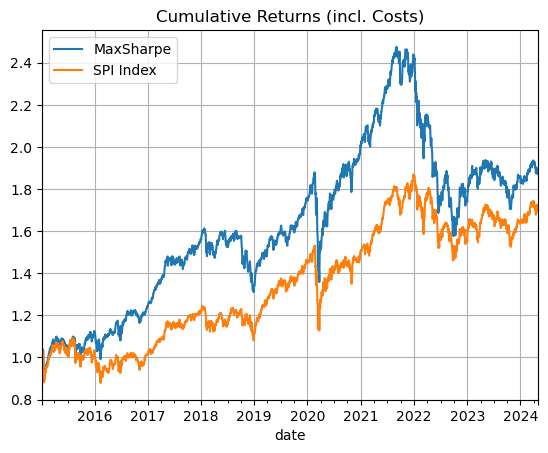

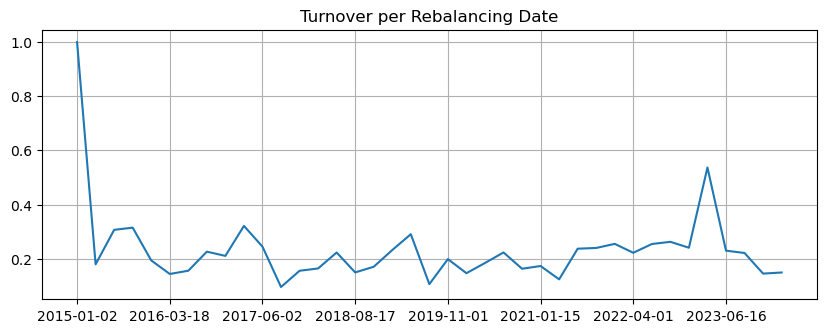

Annualized Turnover ≈ 98.98%

Performance Summary:
           Annual Return  Annual Volatility  Sharpe Ratio  Max Drawdown
MaxSharpe       0.068049           0.141923      0.479478     -0.363083
SPI Index       0.056593           0.145690      0.388450     -0.263289


In [41]:
import matplotlib.pyplot as plt

# 1. Simulate strategy returns with transaction costs
returns = bs.data.get_return_series()
strategy_net = bt_ms.strategy.simulate(return_series=returns, fc=0.01, vc=0.003)

# 2. Compute and plot cumulative returns
spi = bs.data.bm_series  # use as-is
# Align SPI with MaxSharpe and drop missing values
aligned_spi = spi.reindex(strategy_net.index).dropna()
aligned_net = strategy_net.loc[aligned_spi.index]

cumulative = pd.DataFrame({
    'MaxSharpe': (1 + aligned_net).cumprod(),
    'SPI Index': (1 + aligned_spi).cumprod()
})



plt.figure(figsize=(10, 5))
cumulative.plot(title='Cumulative Returns (incl. Costs)')
plt.grid()
plt.show()

# 3. Turnover visualization
turn_series = bt_ms.strategy.turnover(return_series=returns, rescale=False)
plt.figure(figsize=(10, 3.5))
turn_series.plot(title='Turnover per Rebalancing Date')
plt.grid()
plt.show()

# 4. Annualized turnover calculation
idx = pd.to_datetime(turn_series.index)
years = (idx[-1] - idx[0]).days / 365.25
reb_freq = len(idx) / years
annual_turnover = turn_series.mean() * reb_freq
print(f"Annualized Turnover ≈ {annual_turnover:.2%}")

# 5. Summary performance statistics
def summarize_performance(ret):
    ann_ret = (1 + ret).prod()**(252/len(ret)) - 1
    vol = ret.std() * np.sqrt(252)
    sharpe = ann_ret / vol if vol > 0 else np.nan
    wealth = (1 + ret).cumprod()
    drawdown = ((wealth - wealth.cummax()) / wealth.cummax()).min()
    return ann_ret, vol, sharpe, drawdown

stats_data = {
    'MaxSharpe': summarize_performance(strategy_net),
    'SPI Index': summarize_performance(spi.reindex(strategy_net.index).dropna())

}

stats_df = pd.DataFrame(stats_data, index=['Annual Return', 'Annual Volatility', 'Sharpe Ratio', 'Max Drawdown'])
print("\nPerformance Summary:")
print(stats_df.T)

